# Customizing colors, calculating quantile and plotting contours 

In this notebook, we use the function hpmap to generate color shading maps. hpmap is based on datashader and a more detailed explanation please go to: ("I want the link here to Bjorn's [notebook](https://gitlab.dkrz.de/m219063/icon-anal/-/blob/717c904ee742374eb958ee98778e9874afb4c01f/gems/healpix-maps.ipynb), but I doubt that people not having a github account could see it"). We also present a way to customize colormaps (**section 1**). <br> As part of regionalzing the domain to perform statistcs, there are examples in which two methods to cut area of interest are shown (**section 2**). In this case we calculate quantiles.    


**Functions to take into account** <br>
`attach_coords` attaches coordinates to HEALPix data <br>
`hpmap` plots color shading maps of HEALPix data with attached coordinates using data-shader <br>
`nnmap` plots color shading maps of  HEALPix data with attached coordinates using image show. Attaching coordinates for this plot is not needed <br> 
`nncontour` plots contour lines of HEALPix data with attached coordinates using matplotlib contour. Attaching coordinates for this plot is not needed <br>

### Calling packages

In [1]:
import intake
import cartopy.crs as ccrs
import cartopy.feature as cf
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter
import seaborn as sns
import pandas as pd
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm
import datashader as ds
import datashader.transfer_functions as tf

from datashader.mpl_ext import dsshow
import cartopy as cartopy

### Defining functions

In [2]:
def get_nest(ds):
    return ds.crs.healpix_order == "nest"

def get_nside(ds):
    return ds.crs.healpix_nside

def attach_coords(ds):
    lons, lats = hp.pix2ang(get_nside(ds), np.arange(ds.dims["cell"]), nest=get_nest(ds), lonlat=True)
    return ds.assign_coords(
        lat = (("cell",), lats, {"units": "degree_north"}),
        lon = (("cell",), lons, {"units": "degree_east"}),
    )

def hpmap(fld, projection, fig, ax, thrx=1, mp=1, **kwargs):
    """
    Uses datashader to quickly render a dense spatial field form the cartopy projection
    
    fld: a one dimensional list of cells with an associated longitud and latitude for each
    projection: a cartopy map projection for the plot
    thrx: theshold for pixelizaiton
    mp: maximum number of neighboring pizels
    kwargs: additional arguments to dsshow
    """  

    fig.canvas.draw_idle() 
    cx     = projection.transform_points(ccrs.Geodetic(),fld.lon,fld.lat)
    df     = pd.DataFrame(data = {"val" : np.squeeze(fld), "lon" : cx[:,0], "lat" : cx[:,1]})
    artist = dsshow(df, ds.Point('lon','lat'), ds.mean('val')
                    , shade_hook=lambda img: tf.dynspread(img, threshold=thrx, max_px=mp, shape="square")
                    , ax=ax, **kwargs)
    return artist

def get_latlon(nx, ny, ax=None):
    if ax is None:
        ax = plt.gca()

    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    xvals = np.linspace(xlims[0], xlims[1], nx)
    yvals = np.linspace(ylims[0], ylims[1], ny)
    xvals2, yvals2 = np.meshgrid(xvals, yvals)
    latlon = ccrs.PlateCarree().transform_points(ax.projection, xvals2, yvals2, np.zeros_like(xvals2))
    return (latlon)

def nnmap(var, nx=420, ny=260, ax=None, **kwargs):
    """
    var: variable on healpix coordinates (array-like)
    nx: image resolution in x-direction
    ny: image resolution in y-direction
    ax: axis to plot on
    kwargs: additional arguments to imshow
    """
    if ax is None:
        ax = plt.gca()
    ax.set_global()

    if (var.ndim == 1):
        latlon = get_latlon(nx, ny, ax)
        valid = np.all(np.isfinite(latlon), axis=-1)
        points = latlon[valid].T
        pix = hp.ang2pix(
            hp.npix2nside(len(var)), theta=points[0], phi=points[1], nest=True, lonlat=True)
        res = np.full(latlon.shape[:-1], np.nan, dtype=var.dtype)
        return ax.imshow(res, extent=ax.get_xlim()+ax.get_ylim(), origin="lower", **kwargs)
    return ax.imshow(var, extent=ax.get_xlim()+ax.get_ylim(), origin="lower", **kwargs)

### General settings 

`exp_name` experiment <br>
`var` variable to call

In [3]:
cat = intake.open_catalog("https://data.nextgems-h2020.eu/catalog.yaml")
##
model_name, exp_name, var, vmin, vmax, cmap = 'ICON','ngc3028','pr',0.,30.,'magma'
t1,t2         = '2020-02-01','2021-01-31'
##
###Projection to use
clon= -135.5808361
proj = ccrs.EqualEarth(central_longitude=clon)
##
sns.set_context('talk')##appereance of plots for talks
#####transform pr units from kg m-2 s-1 to mm d-1
processing_properties = {
    "pr": dict(time_scale=86400),
    "default": dict(time_scale=1),
}

if var == 'pr':
    var_properties = 'pr'
else:
    var_properties = 'default'

### Plotting settings 

In [4]:
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
def format_axes(ax,proj,xlim=[-180,180],ylim=[-90,90],deltax=30,deltay=15,axes=False,noproj=None):
    if axes==False:
        ax.set_extent([xlim[0], xlim[1], ylim[0], ylim[1]],crs=proj)
        ax.spines.clear()
        ax.coastlines(color='black',lw=1)
    else:
        ax.set_extent([xlim[0], xlim[1], ylim[0], ylim[1]],crs=proj)
        ax.set_yticks(np.arange(ylim[0],ylim[1]+1,deltay))
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.set_xticks(np.arange(xlim[0],xlim[1]-1,deltax), crs=noproj)
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        ax.xaxis.set_major_formatter(lon_formatter)

### Section 1: Shading color maps and customizing colormap

**hpmap with zoom=6**

In [5]:
%%time
exp_z6 = cat[model_name][exp_name](time="P1D",zoom=6, chunks="auto").to_dask()
fld_z6 = attach_coords(exp_z6)[var].sel(
    time=slice(t1,t2)).mean(
    'time')*processing_properties[var_properties]["time_scale"]

CPU times: user 574 ms, sys: 117 ms, total: 691 ms
Wall time: 1.16 s


CPU times: user 889 ms, sys: 289 ms, total: 1.18 s
Wall time: 8.14 s


Text(0.5, 1.0, 'ngc3028 Feb.2020- Jan.2021 - zoom=6')

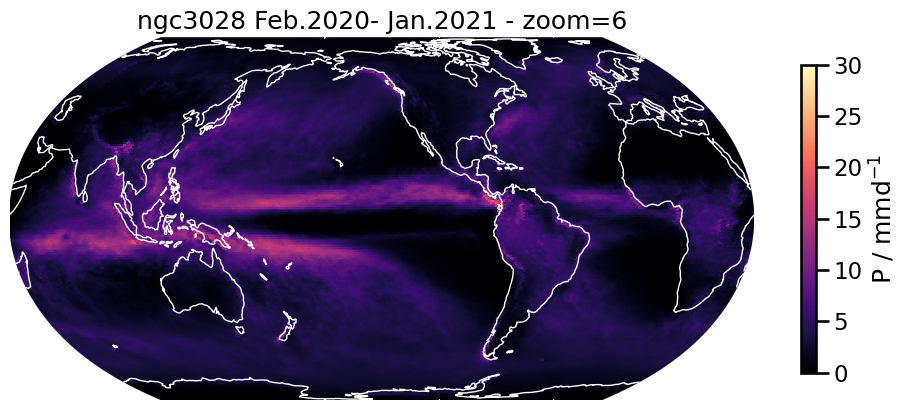

In [6]:
%%time
title = f'{exp_name} Feb.2020- Jan.2021 - zoom=6'
fig, ax = plt.subplots(figsize=(12,8),subplot_kw={"projection": proj})
artist  = hpmap(fld_z6, proj, fig, ax, mp=3,vmin=vmin, vmax=vmax, cmap=cmap)
ax.spines.clear()
ax.coastlines(color='white',lw=1)
fig.colorbar(artist, label='P / mmd$^{-1}$', shrink=0.5)
plt.title(title)


#### Customizing colors

In [7]:
####Generating new colormap
GnBu = cm.get_cmap('YlGnBu', 12)
newcolors = GnBu(np.linspace(0, 1, 12))
white = np.array([1, 1, 1, 1]) #white color
scnd = np.array([0.89051745, 0.76469402, 0.71028506 , 1]) #brown color
newcolors[0, :] = white
newcolors[1, :] = scnd
clevs = [0, 1, 2, 4, 6, 8, 10, 15, 20, 25,
         30, 35]
GnBu_new = ListedColormap(newcolors,'precip')
GnBu_new_norm = BoundaryNorm(clevs,GnBu_new.N)

CPU times: user 155 ms, sys: 117 ms, total: 272 ms
Wall time: 327 ms


Text(0.5, 1.0, 'ngc3028 Feb.2020- Jan.2021 - zoom=6')

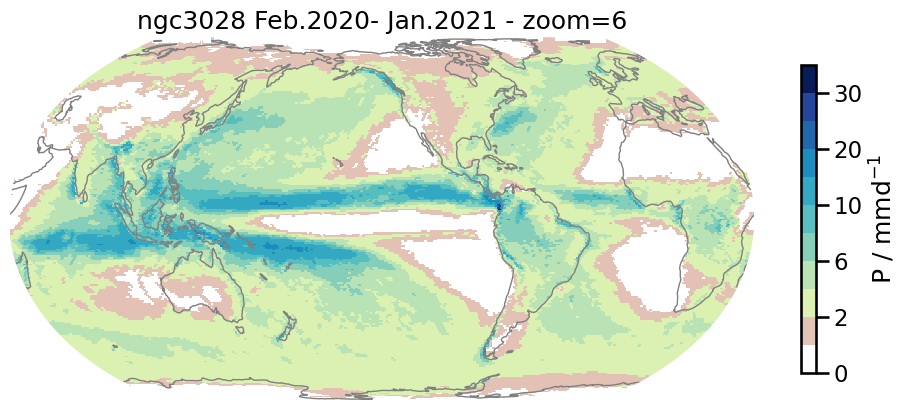

In [8]:
%%time
title         = f'{exp_name} Feb.2020- Jan.2021 - zoom=6'
fig, ax = plt.subplots(figsize=(12,8),subplot_kw={"projection": proj})
artist  = hpmap(fld_z6, proj, fig, ax, mp=3,vmin=vmin, vmax=vmax, cmap=GnBu_new, norm = GnBu_new_norm)

ax.spines.clear()
ax.coastlines(color='gray',lw=1)
fig.colorbar(artist, label='P / mmd$^{-1}$', shrink=0.5)
plt.title(title)

### Section 2: Cutting the tropics and calculate quantile

In [9]:
def nncontour(var,levels=None, nx=420, ny=260, ax=None, smooth=5 ,**kwargs):
    """
    var: variable on healpix coordinates (array-like)
    nx: image resolution in x-direction
    ny: image resolution in y-direction
    ax: axis to plot on
    smooth: the smoothness index for the gaussian filter
    kwargs: additional arguments to imshow
    
    """
    if ax is None:
        ax = plt.gca()
    ax.set_global()

    if (var.ndim == 1):
        latlon = get_latlon(nx, ny, ax)
        valid = np.all(np.isfinite(latlon), axis=-1)
        points = latlon[valid].T
        pix = hp.ang2pix(
            hp.npix2nside(len(var)), theta=points[0], phi=points[1], nest=True, lonlat=True)
        res = np.full(latlon.shape[:-1], np.nan, dtype=var.dtype)
        res[valid] = var[pix]
        res_smooth = gaussian_filter(res, smooth)
        return ax.contour(res_smooth,levels, extent=ax.get_xlim()+ax.get_ylim(), origin="lower", **kwargs)
    res_smooth = gaussian_filter(var, smooth)
    return ax.contour(res_smooth,levels, extent=ax.get_xlim()+ax.get_ylim(), origin="lower", **kwargs)

_Working with zoom 6_

-  First method: using .where to cut the desired region

In [11]:
fld_trop_z6= fld_z6.where((fld_z6.lat>=-30.1) & (fld_z6.lat<=30),drop=True)
quantile_80_z6 = fld_trop_z6.quantile(0.8).values

`nncontour` needs to use the entire data to compute the contour

CPU times: user 722 ms, sys: 262 ms, total: 984 ms
Wall time: 1.2 s


Text(0.5, 1.0, 'ngc3028 Feb.2020- Jan.2021 - zoom=6 - Tropics')

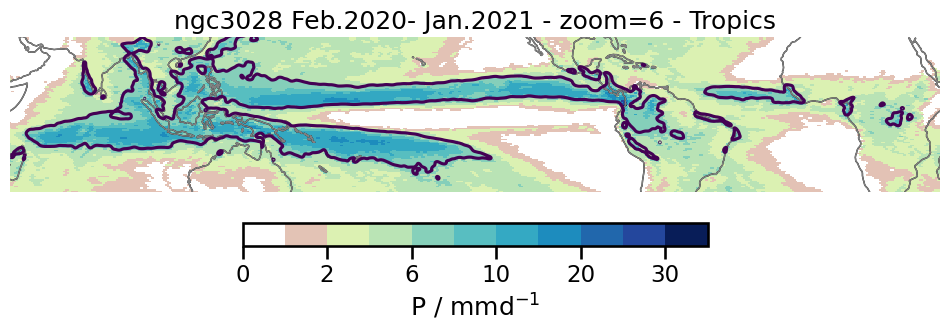

In [15]:
%%time
title         = f'{exp_name} Feb.2020- Jan.2021 - zoom=6 - Tropics'
proj = ccrs.PlateCarree(central_longitude=clon)
fig, ax = plt.subplots(figsize=(12,8),subplot_kw={"projection": proj})
artist  = hpmap(fld_trop_z6, proj, fig, ax, mp=2,vmin=vmin, vmax=vmax, cmap=GnBu_new, norm = GnBu_new_norm)
artist_contour = nncontour(fld_z6,levels=[quantile_80_z6], nx=1260, ny=780, ax=None, smooth=2)

format_axes(ax,proj,xlim=[-180,180],ylim=[-30,30])
ax.coastlines(color='gray',lw=1)
fig.colorbar(artist, label='P / mmd$^{-1}$', shrink=0.5,orientation='horizontal',pad=0.05)
plt.title(title)

-  Second method: For this example the function `ring2nest` is used. This function use the Healpix grid arrangement to cut a latitudinal band. In this case we crop the tropical region (30$^{\circ}$N to 30$^{\circ}$S). Healpix treats the North Pole to be 0$^{\circ}$ and the South Pole to be 180$^{\circ}$. Thus, to cut the tropics we need to go from 60$^{\circ}$ to 120$^{\circ}$

In [16]:
cells = hp.ring2nest(
    get_nside(exp_z6), 
    hp.query_strip(get_nside(exp_z6), 
                   np.deg2rad(60.1), 
                   np.deg2rad(120), 
                   inclusive=True))

fld_trop_z6_2nd= fld_z6.isel(cell=cells)
quantile_80_z6_2nd = fld_trop_z6_2nd.quantile(0.8).values

CPU times: user 724 ms, sys: 242 ms, total: 966 ms
Wall time: 1.09 s


Text(0.5, 1.0, 'ngc3028 Feb.2020- Jan.2021 - zoom=6 - Tropics')

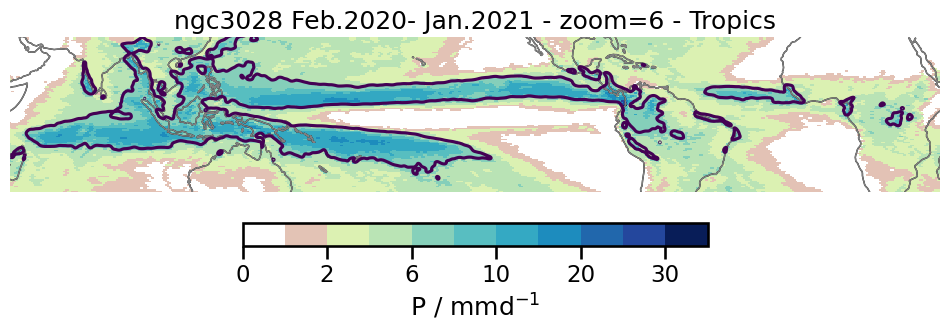

In [19]:
%%time
title         = f'{exp_name} Feb.2020- Jan.2021 - zoom=6 - Tropics'
proj = ccrs.PlateCarree(central_longitude=clon)
fig, ax = plt.subplots(figsize=(12,8),subplot_kw={"projection": proj})
artist  = hpmap(fld_trop_z6_2nd, proj, fig, ax, mp=2,vmin=vmin, vmax=vmax, cmap=GnBu_new, norm = GnBu_new_norm)
artist2 = nncontour(fld_z6,levels=[quantile_80_z6_2nd], nx=1260, ny=780, ax=None, smooth=2)
format_axes(ax,proj,xlim=[-180,180],ylim=[-30,30])
ax.coastlines(color='gray',lw=1)
fig.colorbar(artist, label='P / mmd$^{-1}$', shrink=0.5,orientation='horizontal',pad=0.05)
plt.title(title)